In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from scipy.stats import shapiro, normaltest
from scipy.stats import probplot

CPU times: user 2.48 s, sys: 104 ms, total: 2.58 s
Wall time: 11 s


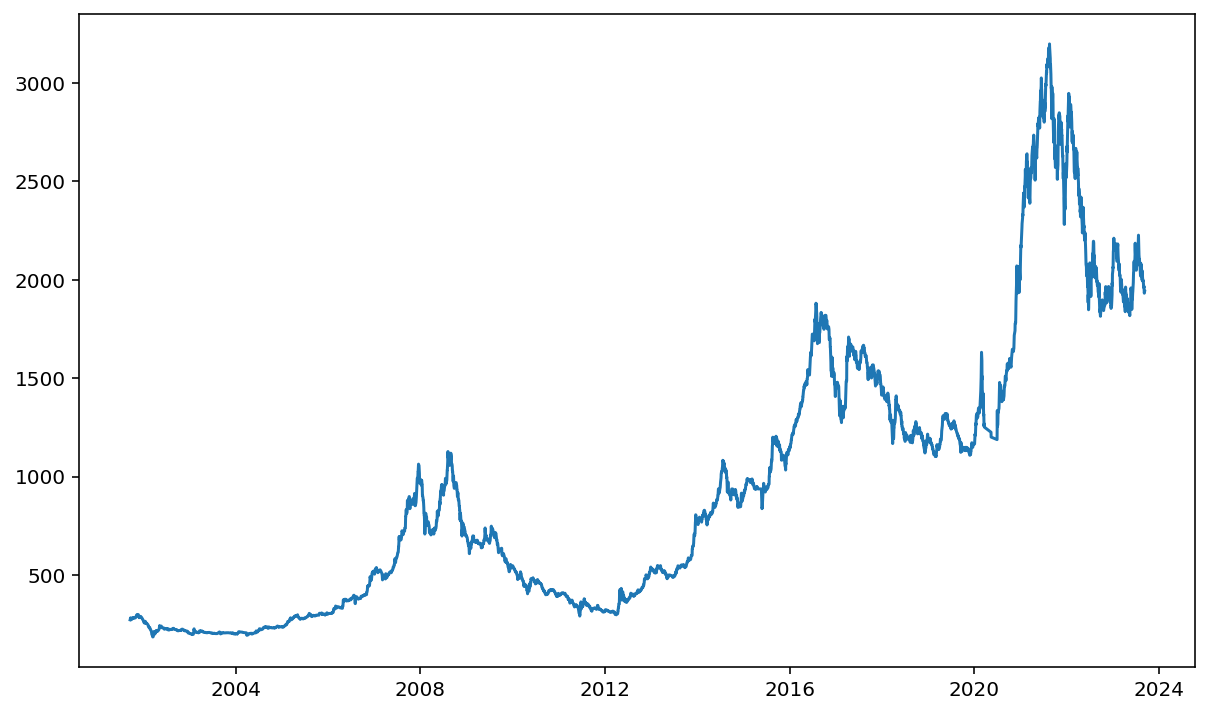

In [6]:
%%time
%config InlineBackend.figure_format = 'retina'
df = pd.read_excel('/Users/prajwal/Desktop/nepse/nepse_vs_sp500 (updated).xlsx')
df = df.set_index(df.Date)
nepse = pd.DataFrame(df.NEPSE)
plt.figure(figsize=(10,6))
plt.plot(nepse)

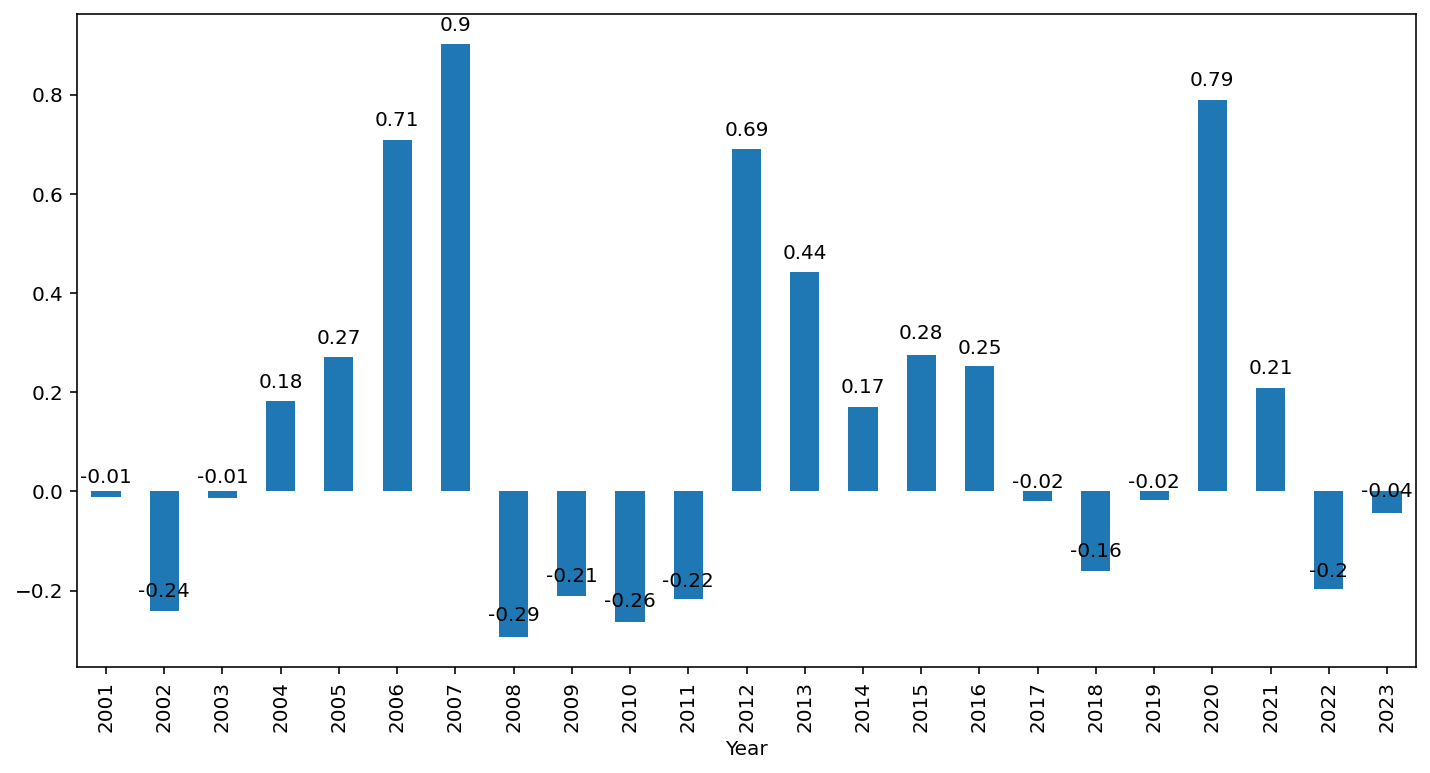

In [9]:
# groupby year and determine the daily percent change by year, and add it as a column to df
nepse['returns'] = nepse.NEPSE.pct_change()
nepse['log_returns'] = np.log(nepse['NEPSE']/nepse['NEPSE'].shift(1))
nepse['year'] = nepse.index.year
nepse['month'] = nepse.index.month
nepse['day_of_the_month'] = nepse.index.day

grouped_by_day = nepse.groupby('day_of_the_month').log_returns.mean()
grouped_by_month = nepse.groupby('month').log_returns.mean()
grouped_by_year = nepse.groupby('year').log_returns.mean()

day_returns = nepse.groupby('day_of_the_month').returns.sum()
month_returns = nepse.groupby('month').returns.sum()
yearly_returns = nepse.groupby('year').returns.sum()

ann_log_rets = nepse.groupby('year').log_returns.sum()

cumulative_yearly_rets = pd.DataFrame(nepse['NEPSE'].pct_change().resample('Y').agg(lambda x: (1+x).prod()-1))
cumulative_yearly_rets['Year'] = cumulative_yearly_rets.index.year
cumulative_yearly_rets = cumulative_yearly_rets.set_index(cumulative_yearly_rets.Year)
cumulative_yearly_rets.NEPSE.plot.bar(figsize=(12,6))

# Add values above the bars
for i, v in enumerate(cumulative_yearly_rets.NEPSE.round(2)):
    plt.text(i, v+0.02, str(v), ha='center', va='bottom')

## Get expected (annualized) returns

In [16]:
def getExpectedReturns(df, price_col_name, annualised=True, frequency='daily'):

    daily_returns = df[price_col_name].pct_change()
    weekly_returns = df[price_col_name].resample('W').mean().pct_change()
    monthly_returns = df[price_col_name].resample('M').mean().pct_change()

    exp_daily_return = daily_returns.mean()
    exp_weekly_return = weekly_returns.mean()
    exp_monthly_return = monthly_returns.mean()

    daily_frequency = 250
    weekly_frequency = 52
    monthly_frequency = 12

    if annualised == True:
        if frequency == 'daily':
            annualised_return = (1+exp_daily_return)**daily_frequency - 1
        elif frequency == 'weekly':
            annualised_return = (1+exp_weekly_return)**weekly_frequency - 1
        elif frequency == 'monthly':
            annualised_return = (1+exp_monthly_return)**monthly_frequency - 1

        return annualised_return
    else:
        if frequency == 'weekly':
            return exp_weekly_return
        elif frequency == 'monthly':
            return exp_monthly_return

    return exp_daily_return



def getAnnualisedStd(df, col_name, return_frequency='daily'):
    daily_returns = df[col_name].pct_change()
    weekly_returns = df[col_name].resample('W').ffill().pct_change()
    monthly_returns = df[col_name].resample('M').ffill().pct_change()

    daily_frequency = 250
    weekly_frequency = 52
    monthly_frequency = 12

    if return_frequency == 'daily':
        var = np.var(daily_returns)
        std = np.std(daily_returns)
        annualised_std = std*np.sqrt(daily_frequency)
        return annualised_std
    elif return_frequency == 'weekly':
        var = np.var(weekly_returns)
        std = np.std(weekly_returns)
        annualised_std = std*np.sqrt(weekly_frequency)
        return annualised_std
    elif return_frequency == 'monthly':
        var = np.var(monthly_returns)
        std = np.std(monthly_returns)
        annualised_std = std*np.sqrt(monthly_frequency)
        return annualised_std

In [18]:
print('annualized returns: ' + str(getExpectedReturns(nepse, 'NEPSE', annualised=True, frequency='daily')))
print('annualized volatility: ' + str(getAnnualisedStd(nepse, 'NEPSE', return_frequency='daily')))

annualized returns: 0.11590762168513224
annualized volatility: 0.19697916576326255


## Returns Histogram

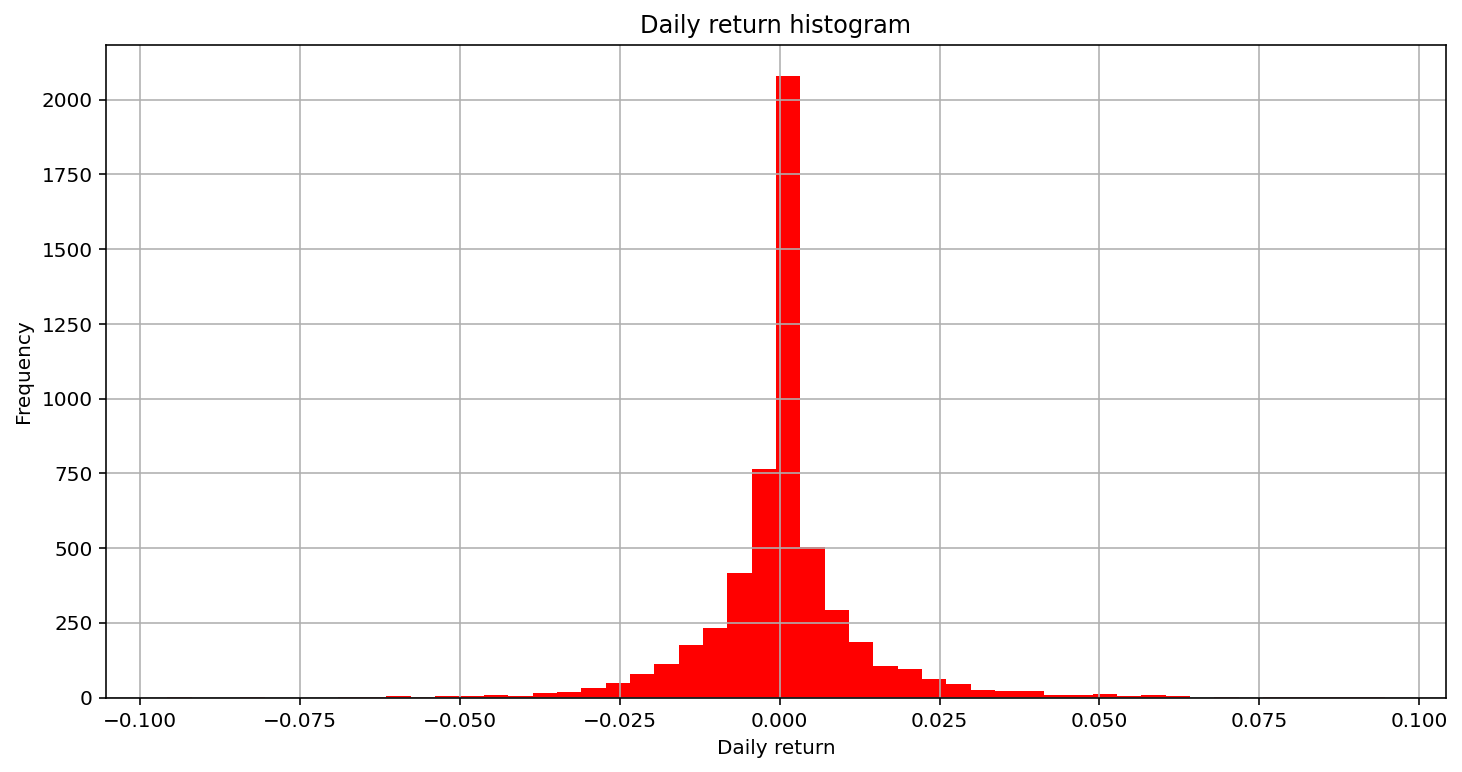

In [19]:
# Plot the histogram
nepse['returns'].hist(bins=50, color='red', figsize=(12,6))
plt.ylabel('Frequency')
plt.xlabel('Daily return')
plt.title('Daily return histogram')
plt.show()

In [20]:
# test for normal distribution
# Perform Shapiro-Wilk test
shapiro_test_statistic, shapiro_p_value = shapiro(nepse.returns.dropna())
print(f"Shapiro-Wilk Test: Statistic = {shapiro_test_statistic}, p-value = {shapiro_p_value}")

# Perform D'Agostino and Pearson's test
k2, p = normaltest(nepse.returns.dropna())
print(f"D'Agostino and Pearson's Test: Statistic = {k2}, p-value = {p}")

Shapiro-Wilk Test: Statistic = 0.8431848287582397, p-value = 0.0
D'Agostino and Pearson's Test: Statistic = 1074.7661328154854, p-value = 4.1447619357639286e-234


/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In both tests, the null hypothesis is that the data is normally distributed. If the p-value is greater than a chosen significance level (e.g., 0.05), you fail to reject the null hypothesis, indicating that the data may be normally distributed. However, if the p-value is below the significance level, you reject the null hypothesis, suggesting that the data does not follow a normal distribution.

Keep in mind that stock returns often exhibit characteristics like fat tails and excess kurtosis, which make them deviate from a perfect normal distribution. Even if the p-values are significant, it's essential to interpret the results carefully and consider the underlying characteristics of financial data. Additionally, visualizations, such as the histogram and Q-Q plots, can provide valuable insights into the distribution's behavior.

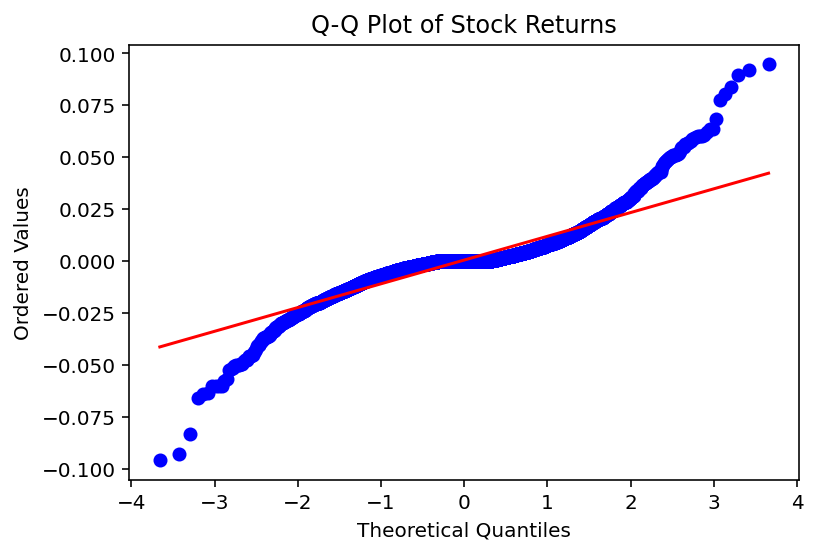

In [21]:
# Plot the Q-Q plot of stock returns against the normal distribution
probplot(nepse.returns.dropna(), plot=plt)
plt.title('Q-Q Plot of Stock Returns')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Ordered Values')
plt.show()

## Volatility 

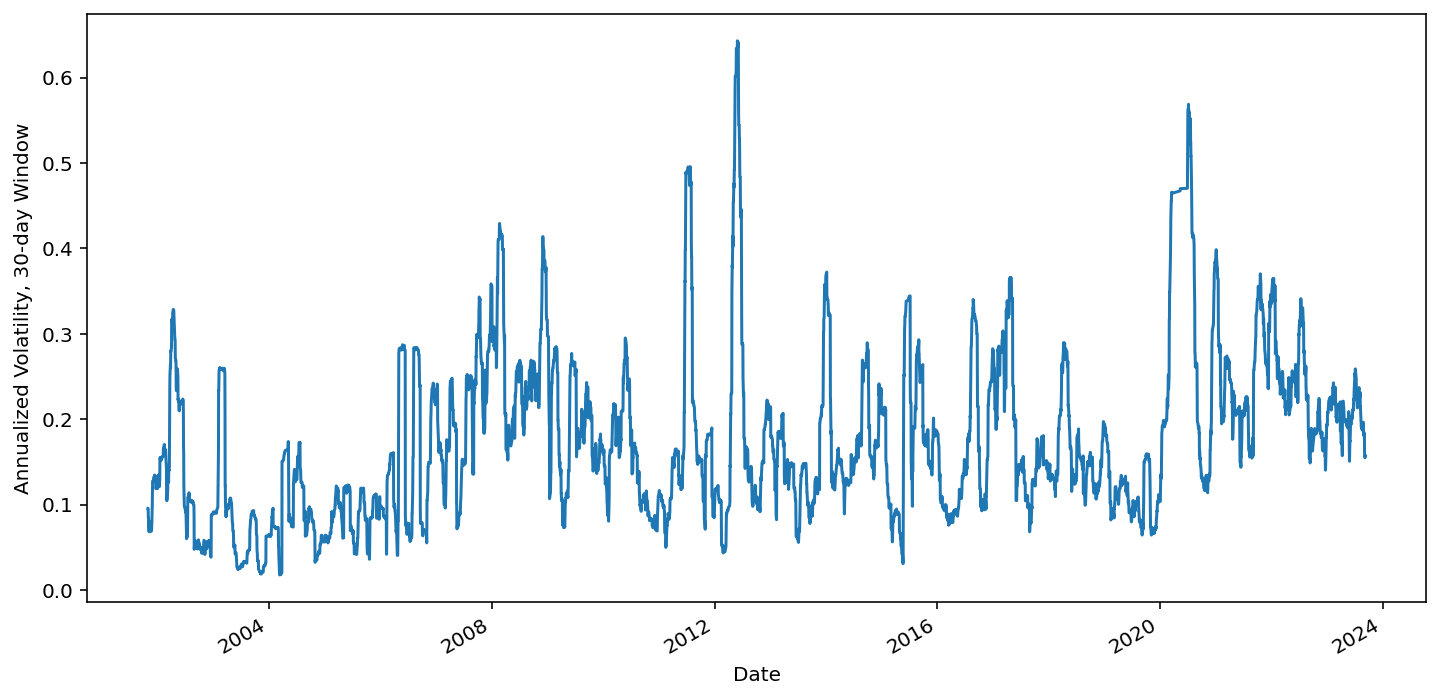

In [22]:
# Calculate the 30-day rolling window of portfolio returns
returns_windowed = nepse.returns.rolling(30)

# Compute the annualized volatility series
volatility_series = returns_windowed.std()*np.sqrt(252)

# Plot the index volatility
volatility_series.plot(figsize=(12,6)).set_ylabel("Annualized Volatility, 30-day Window")
plt.show()

## VaR

In [23]:
from scipy.stats import norm

mlt_mean = np.mean(nepse.NEPSE.resample('M').ffill().pct_change())
mlt_std = np.std(nepse.NEPSE.resample('M').ffill().pct_change())

VaR_90 = norm.ppf(1-0.9, mlt_mean, mlt_std)
VaR_95 = norm.ppf(1-0.95, mlt_mean, mlt_std)
VaR_99 = norm.ppf(1-0.99, mlt_mean, mlt_std)

print(VaR_90)
print(VaR_95)
print(VaR_99)

-0.08526557076157036
-0.11230167339238754
-0.16301690560238333


## Drawdown

In [24]:
def drawdown(rets: pd.Series):
    """
    Takes a timeseries of asset returns
    Computes and returns dataframe that contains:
    the wealth index
    previous peaks
    percentage drawdown
    """
    wealth_index = 1*(1+rets).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks
    return pd.DataFrame({"Wealth": wealth_index, "Peaks":previous_peaks, "Drawdowns": drawdowns})

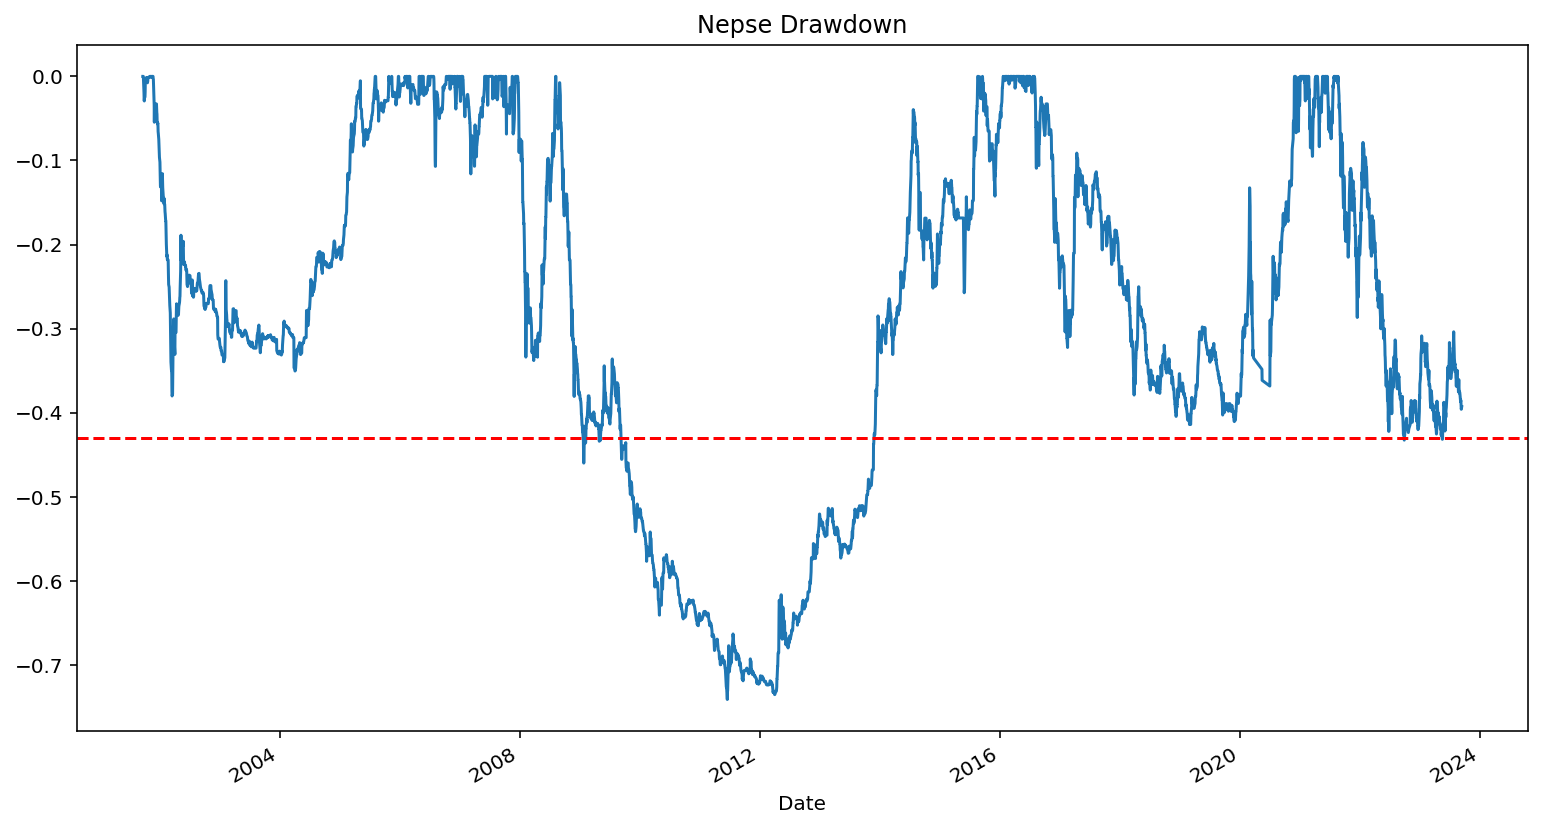

In [25]:
drawdown(nepse.returns).Drawdowns.plot(title='Nepse Drawdown', figsize=(13,7))
plt.axhline(y=-.43, color='r', linestyle='--')

In [26]:
drawdown(nepse.returns)

,Wealth,Peaks,Drawdowns
Date,,,
2001-09-17,NaN,NaN,NaN
2001-09-18,1.007765,1.007765,0.000000
2001-09-19,1.025310,1.025310,0.000000
2001-09-20,1.025310,1.025310,0.000000
2001-09-21,1.037984,1.037984,0.000000
...,...,...,...
2023-09-03,7.182081,11.716054,-0.386988
2023-09-04,7.207904,11.716054,-0.384784
2023-09-05,7.184242,11.716054,-0.386804


In [27]:
def annualize_rets(r, periods_per_year):
    """
    Annualizes a set of returns
    We should infer the periods per year
    but that is currently left as an exercise
    to the reader :-)
    """
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods)-1


def annualize_vol(r, periods_per_year):
    """
    Annualizes the vol of a set of returns
    We should infer the periods per year
    but that is currently left as an exercise
    to the reader :-)
    """
    return r.std()*(periods_per_year**0.5)


def sharpe_ratio(r, riskfree_rate, periods_per_year):
    """
    Computes the annualized sharpe ratio of a set of returns
    """
    # convert the annual riskfree rate to per period
    rf_per_period = (1+riskfree_rate)**(1/periods_per_year)-1
    excess_ret = r - rf_per_period
    ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
    ann_vol = annualize_vol(r, periods_per_year)
    return ann_ex_ret/ann_vol


def summary_stats(r, riskfree_rate=0.03):
    """
    Return a DataFrame that contains aggregated summary stats for the returns in the columns of r
    """

    def annualize_rets(r, periods_per_year):
        compounded_growth = (1+r).prod()
        n_periods = r.shape[0]
        return compounded_growth**(periods_per_year/n_periods)-1

    def annualize_vol(r, periods_per_year):
        return r.std()*(periods_per_year**0.5)

    #def sharpe_ratio(r, riskfree_rate, periods_per_year):
    # convert the annual riskfree rate to per period
     #   rf_per_period = (1+riskfree_rate)**(1/periods_per_year)-1
     #   excess_ret = r - rf_per_period
     #   ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
     #   ann_vol = annualize_vol(r, periods_per_year)
     #   return ann_ex_ret/ann_vol

    #ann_r1=annualize_rets(nepse.returns, periods_per_year=250)
    #ann_vol1=annualize_vol(nepse.returns, 250)

    ann_r = r.aggregate(annualize_rets(nepse.returns, periods_per_year=250))
    ann_vol = r.aggregate(annualize_vol(nepse.returns, 250))
    #ann_sr = r.aggregate(sharpe_ratio, riskfree_rate=riskfree_rate, periods_per_year=12)
    #dd = r.aggregate(lambda r: drawdown(r).Drawdown.min())
    #skew = r.aggregate(skewness)
    #kurt = r.aggregate(kurtosis)
    #cf_var5 = r.aggregate(var_gaussian, modified=True)
    #hist_cvar5 = r.aggregate(cvar_historic)
    return pd.DataFrame({
        "Annualized Return": [ann_r1],
        "Annualized Vol": [ann_vol1],
        #"Skewness": skew,
        #"Kurtosis": kurt,
        #"Cornish-Fisher VaR (5%)": cf_var5,
        #"Historic CVaR (5%)": hist_cvar5,
       # "Sharpe Ratio": ann_sr,
        #"Max Drawdown": dd
    })


# Comparing it with S&P 500

In [28]:
import yfinance as yf
sp = yf.download('^GSPC', start='2001-09-17')['Adj Close']
sp_df = pd.DataFrame(sp)
merge_df = pd.merge(nepse.NEPSE, sp_df, left_index = True, right_index=True)
merge_df.rename(columns={'Adj Close':'S&P500'}, inplace=True)

[*********************100%***********************]  1 of 1 completed


In [29]:
mlt_ret_df = merge_df.pct_change().resample('M').agg(lambda x: (1+x).prod()-1)

In [30]:
import edhec_risk_kit as erk
erk.summary_stats(mlt_ret_df)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish_Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
NEPSE,0.092666,0.257049,0.668764,4.806741,0.144627,0.193277,0.236973,-0.733051
S&P500,0.068112,0.154335,-0.602173,5.285394,0.134320,0.156864,0.240146,-0.525559


<AxesSubplot:xlabel='Date'>

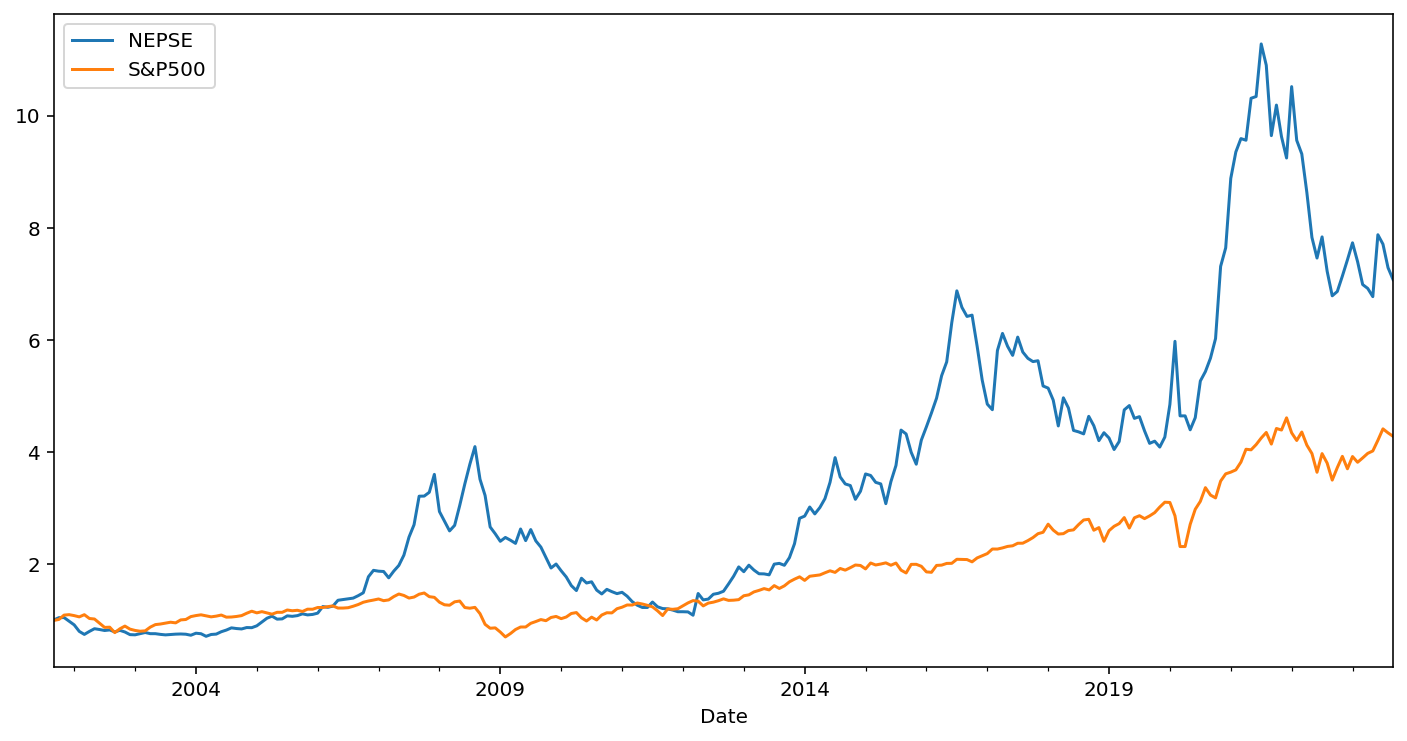

In [31]:
(1+mlt_ret_df).cumprod().plot(figsize=(12,6))

In [32]:
import talib

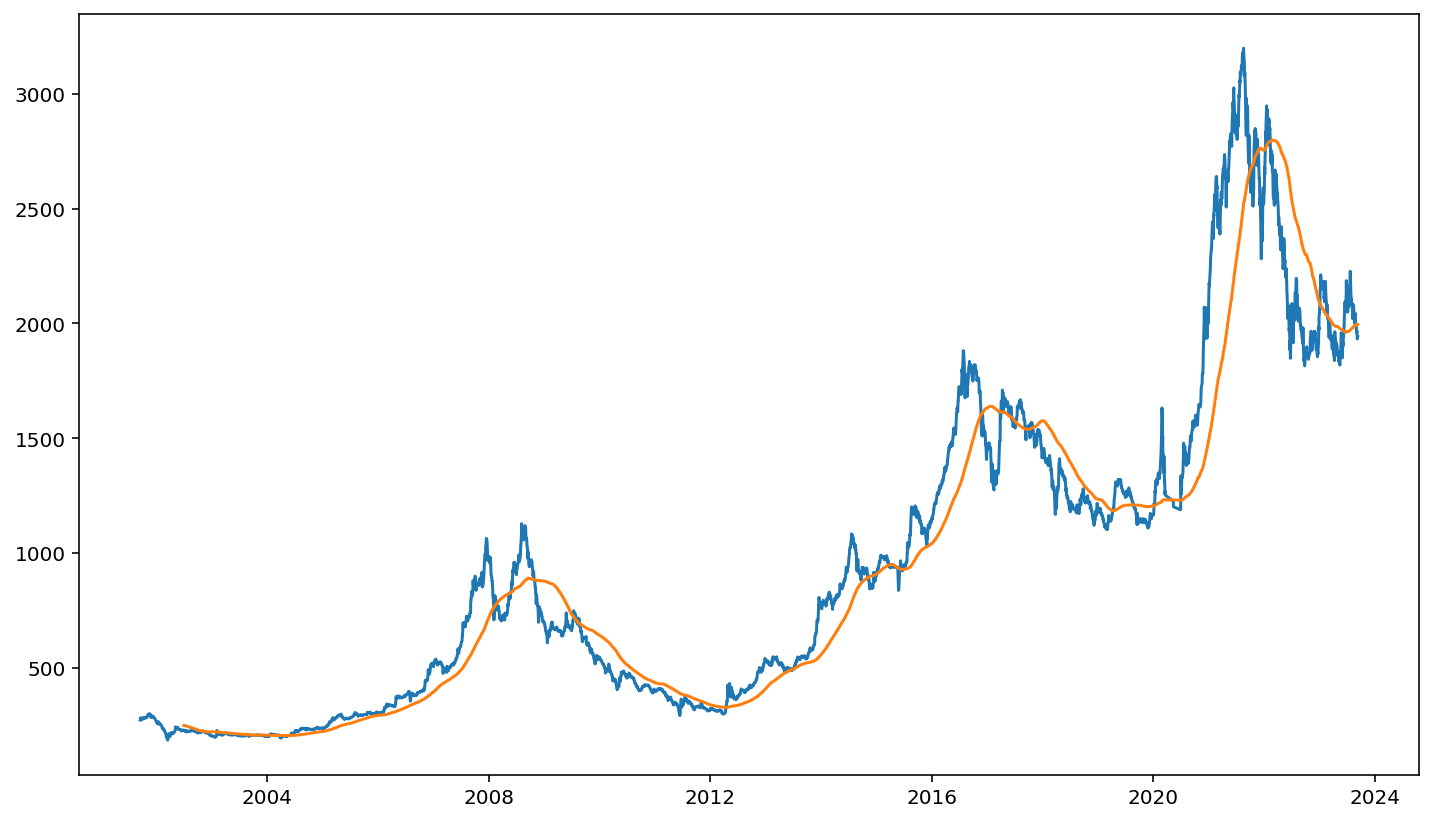

In [36]:
# Moving average using TALIB package
nepse['SMA'] = talib.SMA(nepse['NEPSE'], timeperiod=200)
plt.figure(figsize=(12,7))
plt.plot(nepse.NEPSE)
plt.plot(nepse.SMA)

## 2023 Nepse monthly performance

<ipython-input-51-8b3cffebb3f7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nepse_2023['returns'] = nepse_2023['NEPSE'].pct_change()
<ipython-input-51-8b3cffebb3f7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nepse_2023['year'] = nepse_2023.index.year
<ipython-input-51-8b3cffebb3f7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

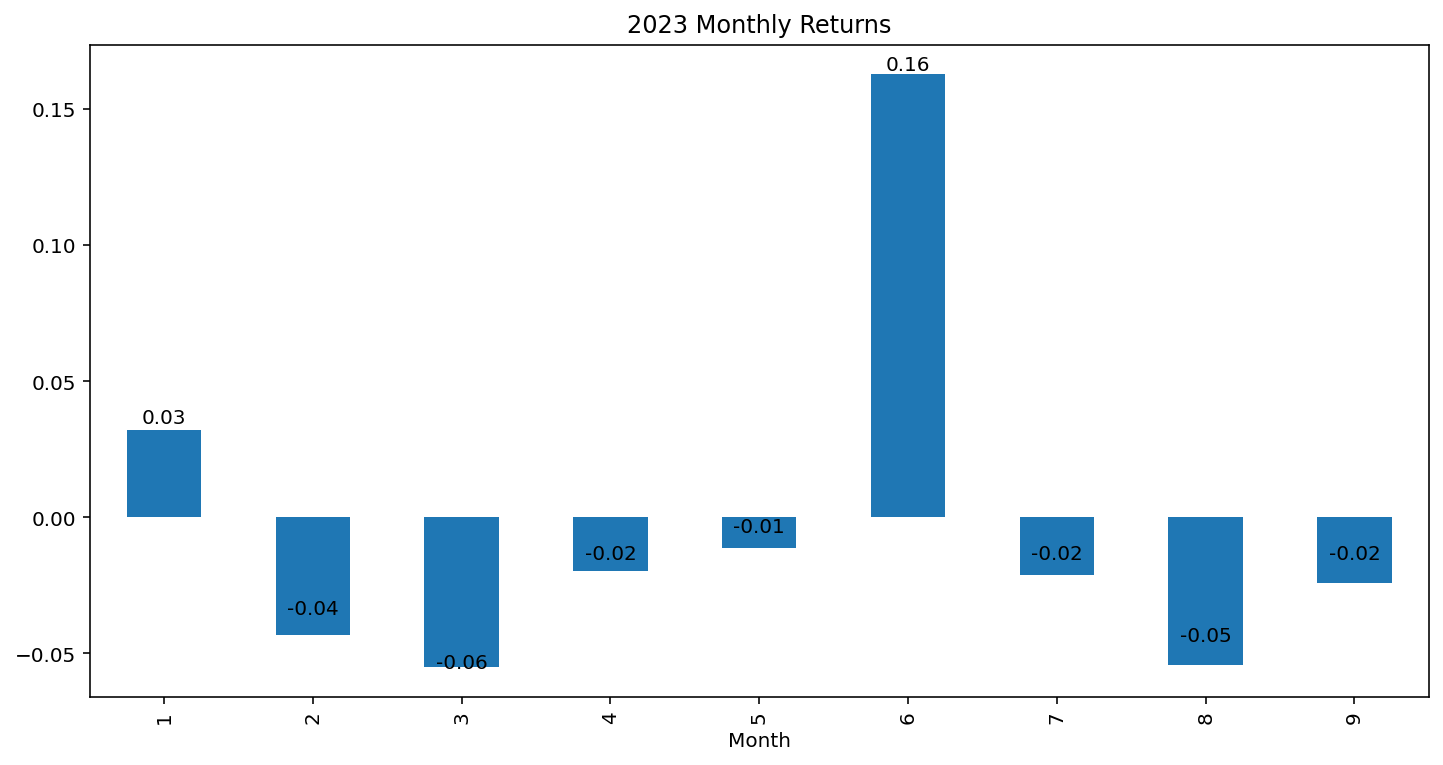

In [51]:
nepse_2023 = nepse.loc['2022-12-31': ]
nepse_2023['returns'] = nepse_2023['NEPSE'].pct_change()
nepse_2023['year'] = nepse_2023.index.year
nepse_2023['month'] = nepse_2023.index.month
nepse_2023['day_of_the_month'] = nepse_2023.index.day


cum_mlt_rets = pd.DataFrame(nepse_2023['NEPSE'].pct_change().resample('M').agg(lambda x: (1+x).prod()-1))
cum_mlt_rets['Month'] = cum_mlt_rets.index.month
cum_mlt_rets = cum_mlt_rets.set_index(cum_mlt_rets.Month)
cum_mlt_rets['NEPSE'].plot.bar(figsize=(12,6), title='2023 Monthly Returns')


# Add values above the bars
for i, v in enumerate(cum_mlt_rets.NEPSE.round(2)):
    plt.text(i, v+0.01, str(v), ha='center', va='top')

<AxesSubplot:title={'center':'2023 Monthly Volatility'}, xlabel='Month'>

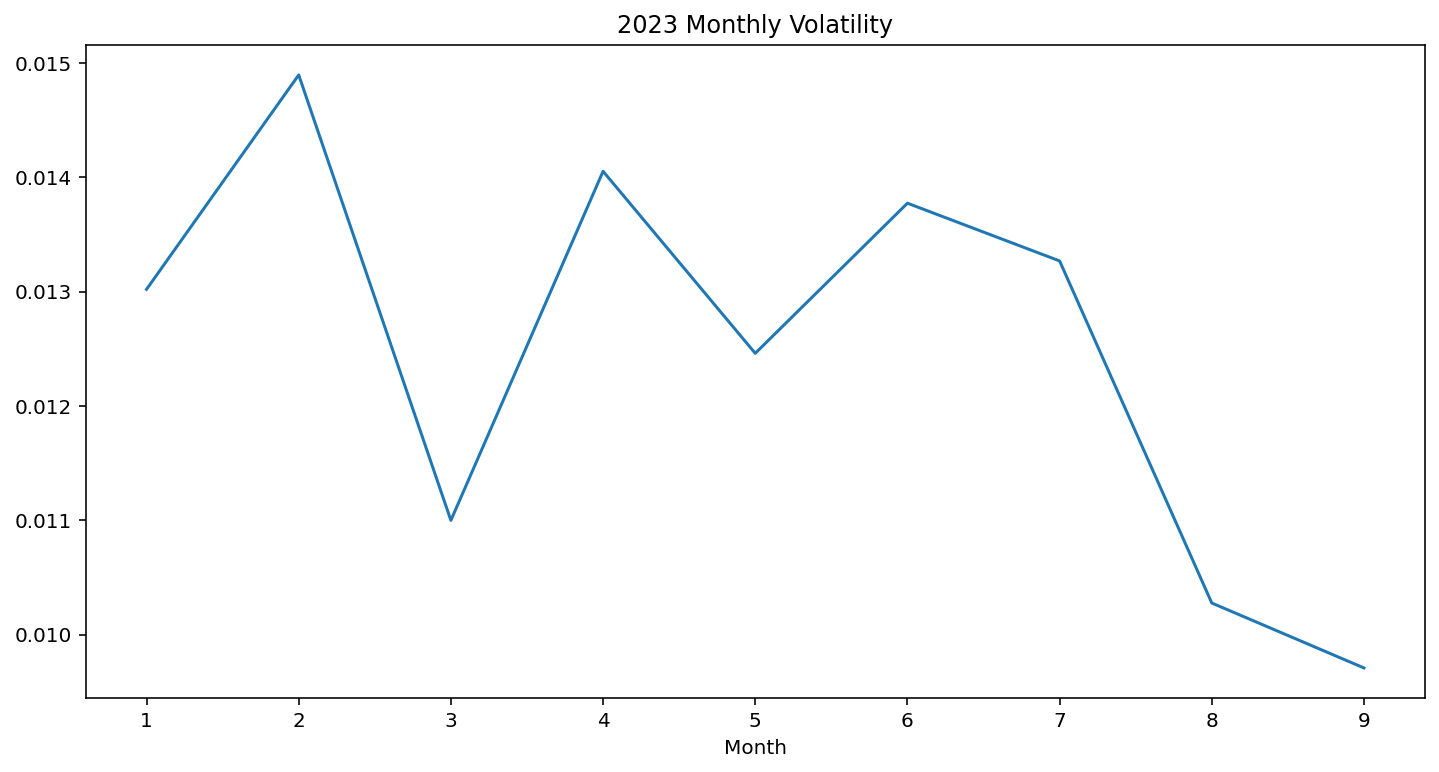

In [96]:
# get monthly volatility for 2023
monthly_volatility_2023 = pd.DataFrame(nepse_2023.resample('M')['returns'].std())
monthly_volatility_2023['Month'] = monthly_volatility_2023.index.month
monthly_volatility_2023 = monthly_volatility_2023.set_index(monthly_volatility_2023.Month)
monthly_volatility_2023 = monthly_volatility_2023.rename(columns={'returns': 'Volatility'})
monthly_volatility_2023['Volatility'].plot.line(figsize=(12,6), title='2023 Monthly Volatility')

In [89]:
x = cum_mlt_rets.index
y1 = cum_mlt_rets.NEPSE
y2 = monthly_volatility_2023.Volatility

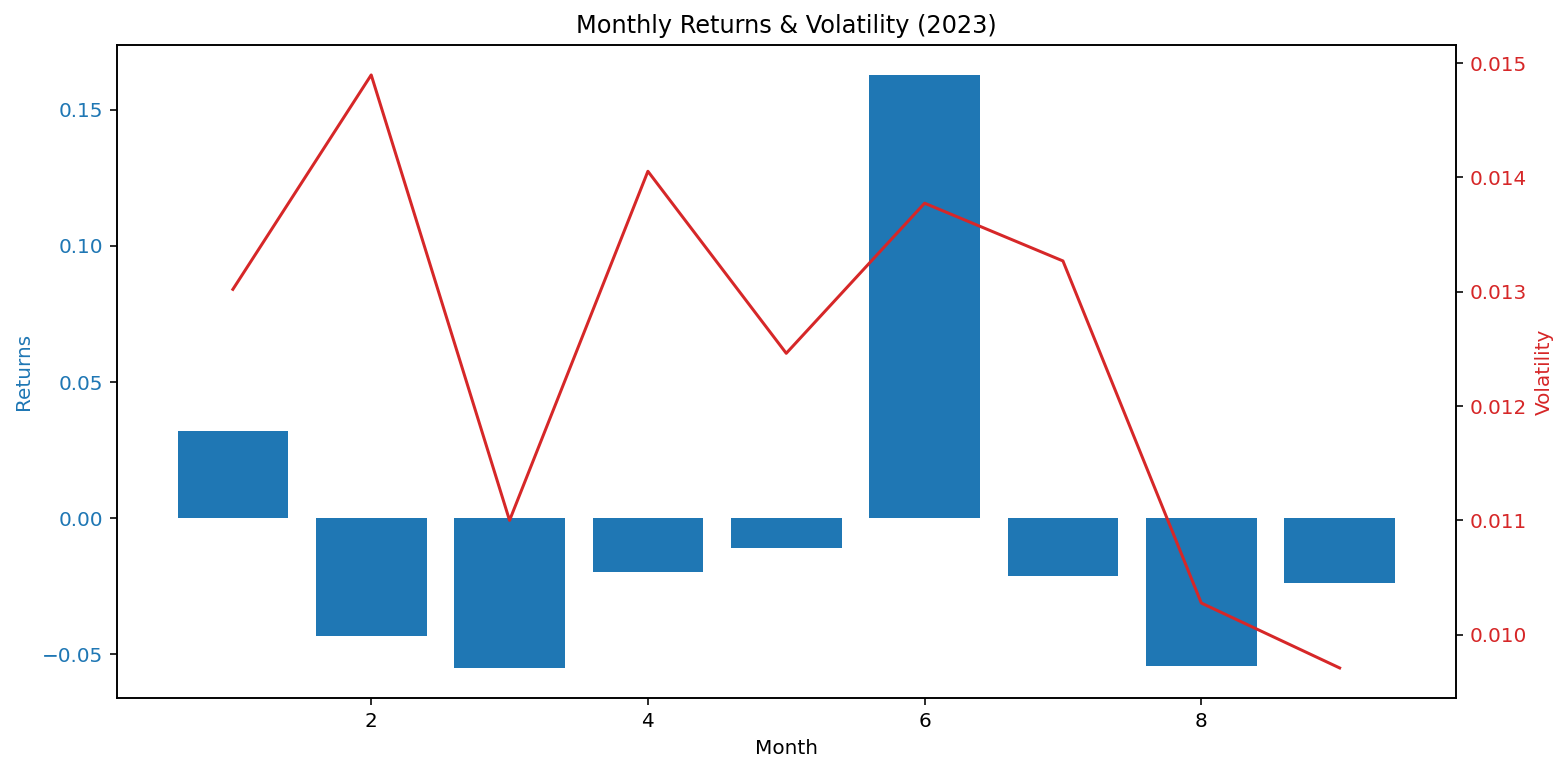

In [107]:
# Create the first plot
fig, ax1 = plt.subplots(figsize=(12,6))

# Plot the first set of data
bars = ax1.bar(x, y1, color='tab:blue')
ax1.set_xlabel('Month')
ax1.set_ylabel('Returns', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create the second y-axis
ax2 = ax1.twinx()

# Plot the second set of data
ax2.plot(x, y2, color='tab:red')
ax2.set_ylabel('Volatility', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Show the plot
plt.title('Monthly Returns & Volatility (2023)')
plt.show()

# Add values above the bars
#for bar in bars:
 #   yval = bar.get_height()
  #  ax1.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom', ha='center', color='tab:blue')